In [2]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# 1. Generate Synthetic Multivariate Data
def generate_data(n_obs=2500):
    np.random.seed(42)
    time = np.arange(n_obs)
    
    # Components
    trend = 0.05 * time
    seasonal = 10 * np.sin(2 * np.pi * time / 50)
    noise = np.random.normal(0, 1, n_obs)
    
    # Target and 4 interacting features
    target = trend + seasonal + noise
    f1 = target * 0.8 + np.random.normal(0, 0.5, n_obs)
    f2 = np.roll(target, 5) * 0.5 + np.random.normal(0, 0.5, n_obs)
    f3 = trend * 0.2 + np.random.normal(0, 2, n_obs)
    f4 = seasonal * 1.5 + np.random.normal(0, 1, n_obs)
    
    df = pd.DataFrame({'target': target, 'f1': f1, 'f2': f2, 'f3': f3, 'f4': f4})
    
    # FIX: Use bfill() instead of fillna(method='bfill')
    return df.bfill()

df = generate_data()
print("Data generated successfully. Shape:", df.shape)

# 2. Windowing Function for Deep Learning
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length, 0] # Predicting 'target'
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)
X, y = create_sequences(scaled_data, seq_length=24)

# Convert to PyTorch tensors
X_train = torch.FloatTensor(X[:2000])
y_train = torch.FloatTensor(y[:2000]).unsqueeze(1)
X_test = torch.FloatTensor(X[2000:])
y_test = torch.FloatTensor(y[2000:]).unsqueeze(1)

print("Preprocessing complete. Training shapes:", X_train.shape, y_train.shape)

Data generated successfully. Shape: (2500, 5)
Preprocessing complete. Training shapes: torch.Size([2000, 24, 5]) torch.Size([2000, 1])


Starting training...
Epoch 5/20, Loss: 0.19550
Epoch 10/20, Loss: 0.04673
Epoch 15/20, Loss: 0.13801
Epoch 20/20, Loss: 0.07197


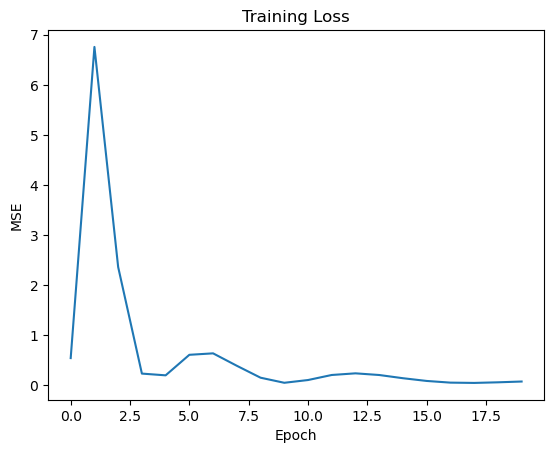

In [3]:
# Transformer Model Definition
class TransformerForecaster(nn.Module):
    def __init__(self, n_features, d_model, nhead, num_layers, dropout=0.1):
        super(TransformerForecaster, self).__init__()
        # batch_first=True is important for our data shape (Batch, Seq_Len, Features)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.input_linear = nn.Linear(n_features, d_model)
        self.output_linear = nn.Linear(d_model, 1)

    def forward(self, x):
        # 1. Project input to d_model dimension
        x = self.input_linear(x)
        # 2. Pass through Transformer
        x = self.transformer_encoder(x)
        # 3. Predict using the features of the last time step
        return self.output_linear(x[:, -1, :])

# Initialize Model
model = TransformerForecaster(n_features=5, d_model=64, nhead=8, num_layers=2)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training Loop
epochs = 20
train_losses = []

print("Starting training...")
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    
    output = model(X_train)
    loss = criterion(output, y_train)
    
    loss.backward()
    optimizer.step()
    
    train_losses.append(loss.item())
    
    if (epoch+1) % 5 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.5f}')

plt.plot(train_losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.show()

In [4]:
# 1. Define LSTM Model
class LSTMForecaster(nn.Module):
    def __init__(self, n_features, hidden_size, num_layers):
        super(LSTMForecaster, self).__init__()
        self.lstm = nn.LSTM(input_size=n_features, hidden_size=hidden_size, 
                            num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        # LSTM output shape: (batch, seq_len, hidden_size)
        lstm_out, _ = self.lstm(x)
        # We only want the output from the last time step
        return self.linear(lstm_out[:, -1, :])

# 2. Initialize and Train LSTM
lstm_model = LSTMForecaster(n_features=5, hidden_size=50, num_layers=2)
lstm_optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

print("Training LSTM Baseline...")
for epoch in range(15): # Short training for demonstration
    lstm_model.train()
    lstm_optimizer.zero_grad()
    out = lstm_model(X_train)
    loss = loss_fn(out, y_train)
    loss.backward()
    lstm_optimizer.step()
    if (epoch+1) % 5 == 0:
        print(f"LSTM Epoch {epoch+1}/15, Loss: {loss.item():.5f}")

Training LSTM Baseline...
LSTM Epoch 5/15, Loss: 0.03786
LSTM Epoch 10/15, Loss: 0.02242
LSTM Epoch 15/15, Loss: 0.01182


In [5]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error

print("Training SARIMA (this might take a few seconds)...")

# We use the raw target column (unscaled) for SARIMA
train_size = 2000
train_data_raw = df['target'].values[:train_size]
test_data_raw = df['target'].values[train_size:]

# Fit SARIMA (Simple order for speed; in real projects you'd tune this)
# Order=(1,1,1) means AR(1), I(1), MA(1)
sarima_model = SARIMAX(train_data_raw, order=(1, 1, 1), seasonal_order=(0, 0, 0, 0))
sarima_fit = sarima_model.fit(disp=False)

# Forecast
sarima_pred = sarima_fit.forecast(steps=len(test_data_raw))
print("SARIMA training complete.")

Training SARIMA (this might take a few seconds)...


C:\Users\Dell\anaconda3\envs\exam_project\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


SARIMA training complete.
